### Estimating dimension

My goal in this notebook is to 
1. Generate data with intrinsic dimension 1
1. implement a parallel version of k-means++ using glom

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load /Users/yoavfreund/projects/shapeology/shapeology_code/scripts/CreateVQs.py
import pickle as pk
import numpy as np
#from numpy import *
from glob import glob
from subprocess import Popen,PIPE
import sys
import traceback
from os import system
from os.path import isfile
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve

def dist2(a,b):
    #print('dist',a,b)
    diff=(a-b)**2
    return np.sum(diff.flatten())

def refineKmeans(data_stream,Reps,per_rep_sample=100,refinement_iter=3):
    _shape=Reps[0].shape
    new_Reps=[np.zeros(_shape) for r in Reps]
    _area=_shape[0]*_shape[1]
    Reps_count=[0.0 for r in Reps]
    error=0
    count=per_rep_sample*len(Reps)
    i=0
    for patch,_ in data_stream: 
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
        i+=1
        if i >= count:
            break
    error /= (count*_area)
    final_Reps=[]
    final_counts=[]
    for i in range(len(new_Reps)):
        if Reps_count[i]>refinement_iter:
            final_Reps.append(new_Reps[i]/Reps_count[i])
            final_counts.append(Reps_count[i])
    return final_Reps,final_counts,error

def Kmeans(data_stream,Reps=[],n=100):
    Reps,Statistics = Kmeanspp(data_stream,Reps,n)
    for i in range(5):
        Reps,final_counts,error = refineKmeans(data_stream,Reps)
        print('refine iteration %2d, error=%7.3f, n_Reps=%5d'%(i,error,len(Reps)))
    return Reps,final_counts

def Kmeanspp(data_stream,Reps=[],n=100):
    
    if len(Reps)==0:
        Reps=[next(data_stream)]

    scale_range=[3,20]
    scale=0
    Statistics=[]
    j=len(Reps)
    i=0
    for patch in data_stream: 
        _min=100000
        #print('\n',len(Reps),end=': ')
        for r in Reps:
            _min=min(_min,dist2(patch,r))
            #print(_min,end=', ')

        if scale==0:
            scale=_min*(scale_range[0]+scale_range[1])/2.
        elif scale/_min<scale_range[0]:   # 
            scale=_min*scale_range[1]
            print('increased scale to',scale)
        elif scale/_min>scale_range[1]:
            scale=scale*0.999
            #print('scale=',scale)

        Prob=_min/scale
        i+=1
        if i%100==0:
            print('\r','i=%10d,  #reps=%10d  Prob=%8.6f, scale=%8.6f'%(i,len(Reps),Prob,scale),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

def plot_statistics(Statistics,alpha=0.1,_start=3): 
    N=[x[1] for x in Statistics]
    d=[np.sqrt(x[2]) for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    j=1
    for x in d[_start:]:
        a=alpha/sqrt(j)
        j+=1
        s=(1-a)*s + a*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')


## One dimensional data

In [3]:
#one dimensional data
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
def circlePlusNoise(dim=2,noise_level=0,rotate=None,color=False,radius=1):
    np.random.seed()
    while True:
        angle=np.random.uniform(0,2*np.pi)
        if angle<pi:
            c=0
        else:
            c=1
            
        x = np.zeros(dim)
        x[0]=np.sin(angle)* radius
        x[1]=np.cos(angle)* radius
        x=x+np.random.normal(0,noise_level,dim)
        if rotate is None:
            y=x
        else:
            y=np.dot(rotate,x)
        y=np.array([y])
        if color:
            #print('yield',y,c)
            yield y,c
        else:
            yield y


In [4]:
from numpy.linalg import norm
#two dimensional data
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
def Sinusoidal(dim=2,noise_level=0,rotate=None,color=False,radius=1):
    x = np.zeros(dim)
    np.random.seed()
    while True:
        angle=np.random.uniform(0,10*np.pi)
        for i in range(dim):
            x[i]=np.sin(dim*(i+3)*angle)
        
        if int(dim*angle / np.pi) % 2 == 1:
            c=0
        else:
            c=1

        x=x+np.random.normal(0,noise_level,dim)
        if rotate is None:
            y=x
        else:
            y=np.dot(rotate,x)
        y=np.array([y])
        if color:
            #print('yield',y,c)
            yield y,c
        else:
            yield y


In [5]:
from matplotlib.ticker import MultipleLocator,LogLocator
def plotDim(gen_func,dim=10, R=None, nrep=10,**kwarg):
    X=[]; Y=[]; c=[]; i=0
    if not R is None:
        R=ortho_group.rvs(dim=dim)
    for x,color in gen_func(dim=dim,color=True,rotate=R,**kwarg):
        X.append(x[0,0])
        Y.append(x[0,1])
        c.append(color)
        i+=1
        if i>1000:
            break
    fig, axes = plt.subplots(1,2,figsize=(12,5))
    ax=axes[0]
    ax.scatter(X,Y,c=c,s=1,cmap=plt.cm.jet);
    _title=str(kwarg)+', dim=%d'%dim
    plt.title(_title);

    ########
    generator=gen_func(dim=dim,rotate=R,**kwarg)

    Reps,Statistics=Kmeanspp(generator,n=nrep)

    M=concatenate([Rep for Rep in Reps])

    n,m = M.shape
    i=0
    aver_min=np.zeros(n-1)
    for x in generator:
        X=np.repeat(x,n,axis=0)
        D=(X-M)**2
        d=np.sum(D,axis=1)
        d=np.sqrt(d)
        min_d = np.array([np.min(d[:i]) for i in range(1,len(d))])
        aver_min += min_d
        i+=1
        if i>1000:
            break

    aver_min /= i
    ax1=axes[1]
    ax1.loglog(range(1,n),aver_min)
    #ax1.set_yticklabels(['']*len(ax1.get_yticklabels()))
    step=(aver_min[0]/aver_min[-1])**(1./5)
    y_major = LogLocator(base=step)
    #y_minor = MultipleLocator(np.sqrt(step))
    ax1.yaxis.set_major_locator(y_major)
    majorFormatter = FormatStrFormatter('%6.2e')
    ax1.yaxis.set_major_formatter(majorFormatter)
    #ax1.yaxis.set_minor_locator(y_minor)

    #step=(aver_min[-1]-aver_min[0])/10
    #ax1.get_yaxis().get_major_formatter().labelOnlyBase = False

    ax1.grid()
    plt.title(_title);
    plt.xlabel('#Centers')
    plt.ylabel('E(d)')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

    plt.show();

 i=      7600,  #reps=        97  Prob=0.025925, scale=0.0261289

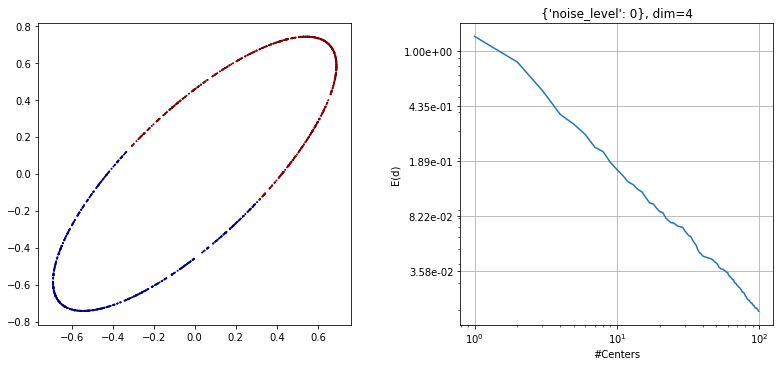

increased scale to 3.7414793288882073
 i=      3200,  #reps=        72  Prob=0.013848, scale=0.195148increased scale to 1.410624874029232
 i=      4700,  #reps=        99  Prob=0.007472, scale=0.332642

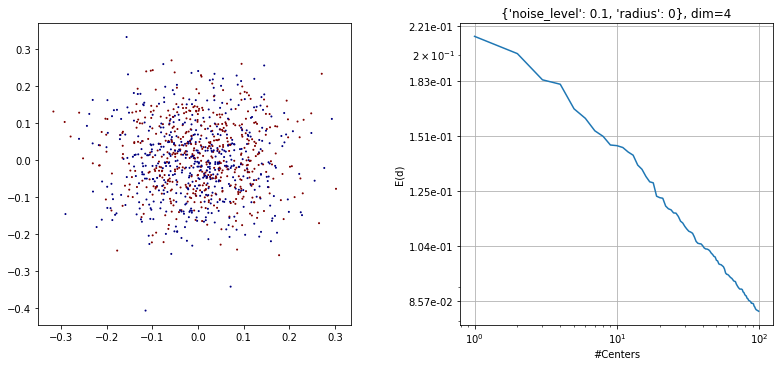

 i=      6400,  #reps=        92  Prob=0.021775, scale=0.0341989

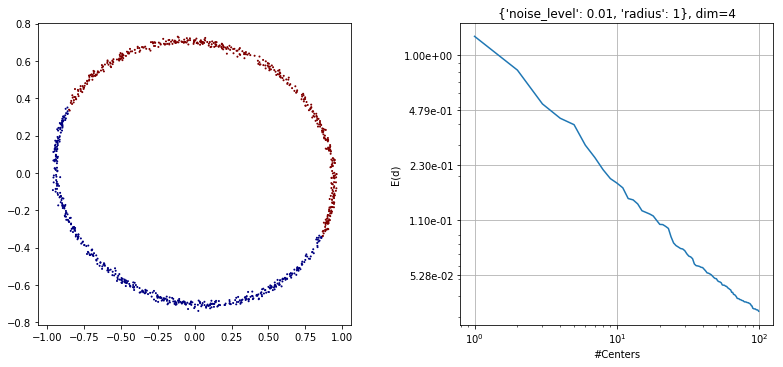

 i=      5000,  #reps=        99  Prob=0.023711, scale=0.5588012

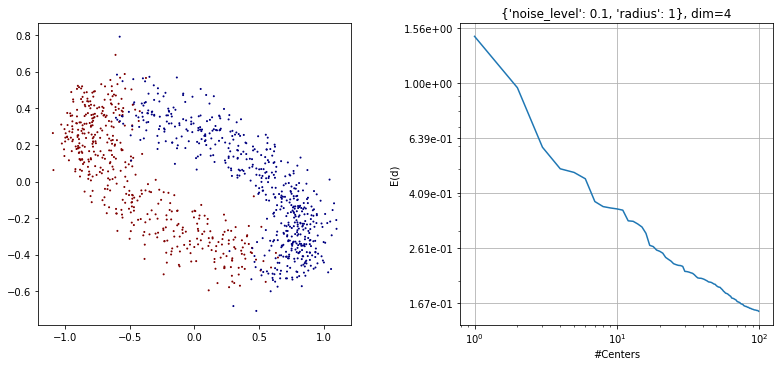

In [6]:
# dim=4
#no noise
plotDim(circlePlusNoise,dim=4,noise_level=0,nrep=100,R=1)

#only noise
plotDim(circlePlusNoise,dim=4,nrep=100,noise_level=0.1,radius=0,R=1)

#circle+ little noise
plotDim(circlePlusNoise,dim=4,nrep=100,noise_level=0.01,radius=1,R=1)

#circle+ little noise
plotDim(circlePlusNoise,dim=4,nrep=100,noise_level=0.1,radius=1,R=1)

 i=      8600,  #reps=       119  Prob=0.006215, scale=0.0098715increased scale to 0.06857190531234703
 i=     11300,  #reps=       167  Prob=0.072230, scale=0.006352increased scale to 0.05108758183017439
 i=     14800,  #reps=       235  Prob=0.000014, scale=0.002354increased scale to 0.017555496401956944
 i=     17000,  #reps=       270  Prob=0.045200, scale=0.002405increased scale to 0.016008256586456434
 i=     19800,  #reps=       322  Prob=0.012857, scale=0.001332increased scale to 0.010845682238401148
 i=     21900,  #reps=       348  Prob=0.028700, scale=0.001568increased scale to 0.011042363687779284
 i=     24600,  #reps=       391  Prob=0.000268, scale=0.000957increased scale to 0.007810080547792492
 i=     27400,  #reps=       441  Prob=0.060752, scale=0.000647increased scale to 0.004281295439635305
 i=     30000,  #reps=       497  Prob=0.023629, scale=0.000457increased scale to 0.0030486151086906383
 i=     32000,  #reps=       540  Prob=0.000598, scale=0.000519increased 

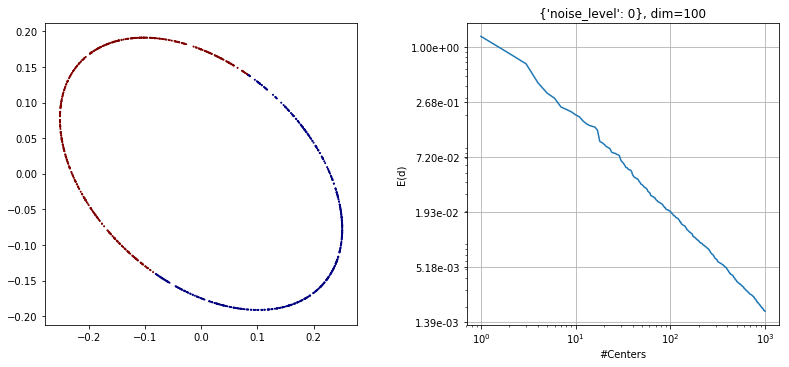

 i=     15600,  #reps=       997  Prob=0.059483, scale=19.918963

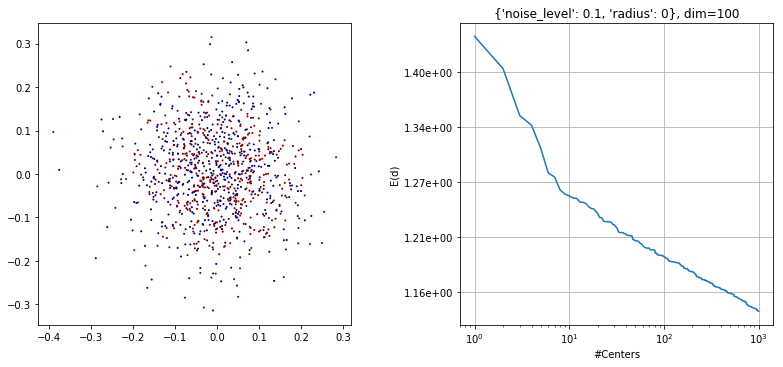

 i=     19500,  #reps=       997  Prob=0.068536, scale=0.2460544

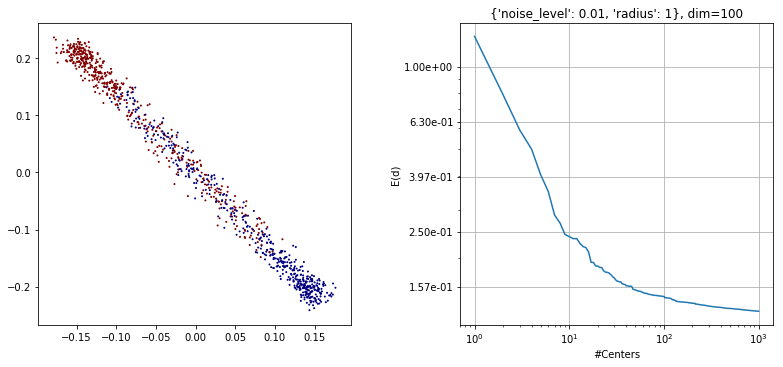

 i=     16400,  #reps=       997  Prob=0.059516, scale=22.059520

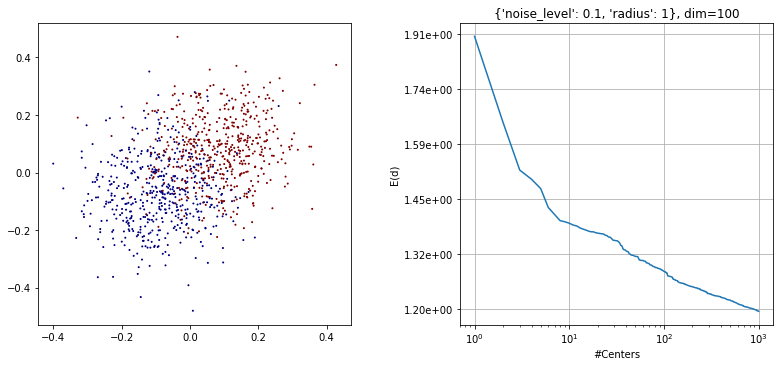

In [7]:
# dim=100
#no noise
plotDim(circlePlusNoise,dim=100,noise_level=0,nrep=1000,R=1)

#only noise
plotDim(circlePlusNoise,dim=100,nrep=1000,noise_level=0.1,radius=0,R=1)

#circle+ little noise
plotDim(circlePlusNoise,dim=100,nrep=1000,noise_level=0.01,radius=1,R=1)

#circle+ little noise
plotDim(circlePlusNoise,dim=100,nrep=1000,noise_level=0.1,radius=1,R=1)

## High/Low/High

increased scale to 27.51811075570727
 i=      7000,  #reps=       154  Prob=0.023801, scale=0.0522200increased scale to 0.458696061547191
 i=      9800,  #reps=       199  Prob=0.038687, scale=0.037907

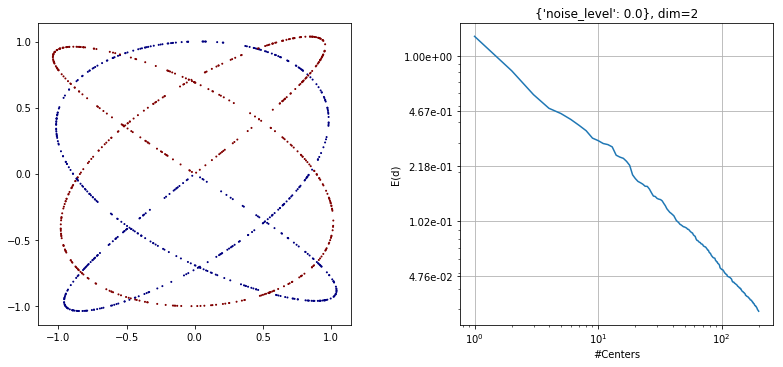

In [8]:
plotDim(Sinusoidal,dim=2,noise_level=0.0,nrep=200,R=1)

 i=      4100,  #reps=       167  Prob=0.000717, scale=7.09328989increased scale to 50.499278778284065
 i=      6000,  #reps=       195  Prob=0.004819, scale=9.2267703

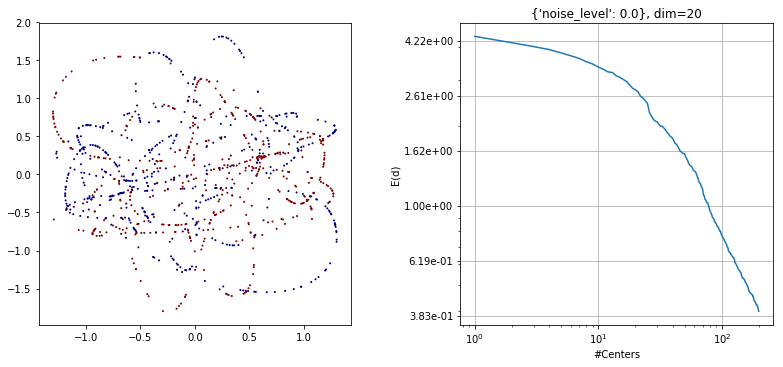

In [9]:
plotDim(Sinusoidal,dim=20,noise_level=0.0,nrep=200,R=1)

 i=      3800,  #reps=       140  Prob=0.011799, scale=13.7525757increased scale to 91.71395724106179
 i=      7500,  #reps=       230  Prob=0.014587, scale=4.035429increased scale to 29.514148361649205
 i=      9400,  #reps=       275  Prob=0.003093, scale=5.212203increased scale to 35.75534232275593
 i=     12300,  #reps=       332  Prob=0.020126, scale=2.662860increased scale to 25.232167880413368
 i=     15600,  #reps=       396  Prob=0.016292, scale=1.410123increased scale to 9.846391728501153
 i=     18100,  #reps=       450  Prob=0.017864, scale=1.134310increased scale to 7.556882227600546
 i=     20200,  #reps=       494  Prob=0.018058, scale=1.223295increased scale to 8.05331988623113
 i=     22500,  #reps=       531  Prob=0.036152, scale=1.050289increased scale to 7.26065064069902
 i=     24800,  #reps=       579  Prob=0.021803, scale=0.902512increased scale to 5.997674669638796
 i=     27100,  #reps=       630  Prob=0.012740, scale=0.794821increased scale to 5.18781785188951

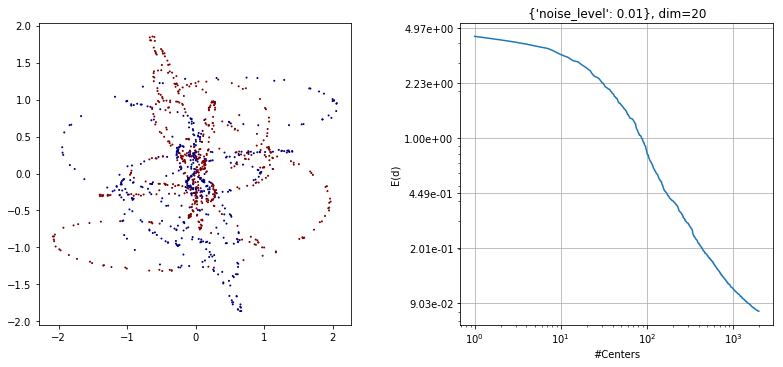

In [10]:
plotDim(Sinusoidal,dim=20,noise_level=0.01,nrep=2000,R=1)

 i=      3800,  #reps=       161  Prob=0.044923, scale=15.473299increased scale to 103.08618206439535
 i=      6300,  #reps=       226  Prob=0.027333, scale=11.911283increased scale to 83.88234571891644
 i=     26300,  #reps=      1996  Prob=0.099066, scale=3.0396927

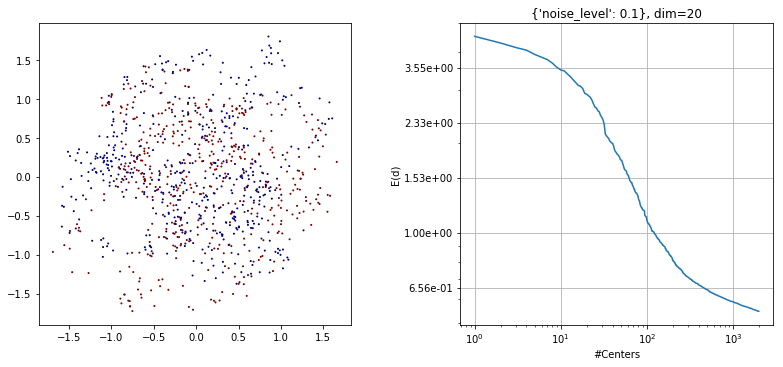

In [11]:
plotDim(Sinusoidal,dim=20,noise_level=0.1,nrep=2000,R=1)

 i=      7300,  #reps=       382  Prob=0.084822, scale=5.718013increased scale to 39.24657932199677
 i=     26300,  #reps=      1997  Prob=0.058550, scale=3.0758809

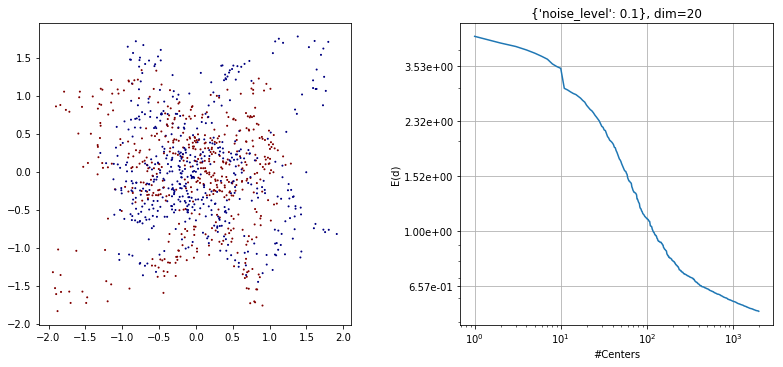

In [12]:
plotDim(Sinusoidal,dim=20,noise_level=0.1,nrep=2000,R=1)

In [13]:
!pwd

/Users/yoavfreund/projects/edx-micro-master-in-data-science.old/big-data-analytics-using-spark/notebooks/Section3-Kmeans-dim-reduction/4.K-Means
